# Modelling

### Libraries

In [2]:
# import libraries

import joblib

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from statsmodels.tsa.holtwinters import SimpleExpSmoothing
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_predict
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error

### Data

In [3]:
# load negative, neutral and positive time series

negative_reviews_per_month = pd.read_csv('features/negative_reviews_per_month.csv', index_col=0, parse_dates=True)
neutral_reviews_per_month = pd.read_csv('features/neutral_reviews_per_month.csv', index_col=0, parse_dates=True)
positive_reviews_per_month = pd.read_csv('features/positive_reviews_per_month.csv', index_col=0, parse_dates=True)

In [4]:
# load sentiment time series

sentiment_per_month = pd.read_csv('features/sentiment_per_month.csv', index_col=0, parse_dates=True)

In [5]:
# load categories time series

sentiment_restaurants_per_month = pd.read_csv('features/sentiment_restaurants_per_month.csv', index_col=0, parse_dates=True)
sentiment_nightlife_per_month = pd.read_csv('features/sentiment_nightlife_per_month.csv', index_col=0, parse_dates=True)
sentiment_breakfast_brunch_per_month = pd.read_csv('features/sentiment_breakfast_brunch_per_month.csv', index_col=0, parse_dates=True)

### Models

In [ ]:
# load ARMA models

negative_arimax = joblib.load('models/negative_arimax.pkl')
neutral_arimax = joblib.load('models/neutral_arimax.pkl')
positive_arimax = joblib.load('models/positive_arimax.pkl')

sentiment_arma = joblib.load('models/sentiment_arma.pkl')

restaurant_arma = joblib.load('models/restaurant_arma.pkl')
nightlife_arma = joblib.load('models/nightlife_arma.pkl')
breakfast_brunch_arma = joblib.load('models/breakfast_brunch_arma.pkl')

In [87]:
def baseline_model(data, method='mean'):
    '''
    Baseline model to predict the next value in a time series
    '''
    if method == 'mean':
        return data.mean()
    elif method == 'median':
        return data.median()
    elif method == 'naive':
        return data.iloc[-1]
    else:
        raise ValueError('Method not supported')

In [88]:
def ses_model(data):
    '''
    Simple Exponential Smoothing model
    '''
    model = SimpleExpSmoothing(data)
    fitted_model = model.fit()
    prediction = fitted_model.forecast(1)
    return prediction.iloc[0]

In [89]:
def holt_linear_damped_model(data):
    '''
    Holt Linear Trend model with damping
    '''
    model = ExponentialSmoothing(data, trend='add', damped_trend=True)
    fitted_model = model.fit()
    prediction = fitted_model.forecast(1)
    return prediction.iloc[0]

In [92]:
models = {
    'baseline_mean': lambda x: baseline_model(x, method='mean'),
    'baseline_median': lambda x: baseline_model(x, method='median'),
    'baseline_naive': lambda x: baseline_model(x, method='naive'),
    'ses': lambda x: ses_model(x),
    'holt_linear_damped': lambda x: holt_linear_damped_model(x)
}

### Predictions

In [93]:
# lambda values

lambda_negative = 0.2
lambda_neutral = 0.2
lambda_positive = 0.2
lambda_sentiment = 2
lambda_restaurants = 0.5
lambda_nightlife = 0.5
lambda_breakfast_brunch = 0.5

In [94]:
def inverse_boxcox(transformed_y, lambda_value):
    '''
    Function to inverse Box-Cox transformation (to obtain forecast in original scale)
    '''
    if lambda_value == 0:
        return np.exp(transformed_y)
    else:
        return np.exp(np.log(transformed_y * lambda_value + 1) / lambda_value)

In [95]:
def cross_validation_predictions(data, model, min_train_size=12):
    '''
    Function to perform cross-validation and obtain predictions
    '''
    results = []
    for i in range(min_train_size, len(data)):
        train = data.iloc[:i]
        test = data.iloc[i:i+1]
        prediction = model(train)
        if not test.empty:
            result_entry = {'date': test.index[0], 'actual': test.iloc[0], 'prediction': prediction}
            results.append(result_entry)
    return pd.DataFrame(results)

### Evaluation

In [96]:
def mean_absolute_percentage_error(y_true, y_pred):
    '''
    Mean Absolute Percentage Error (MAPE) metric
    '''
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [97]:
def mean_absolute_scaled_error(y_true, y_pred, y_train):
    '''
    Mean Absolute Scaled Error (MASE) metric
    '''
    y_true, y_pred, y_train = np.array(y_true), np.array(y_pred), np.array(y_train)
    naive_forecast = y_train[1:] - y_train[:-1]
    mae_naive = np.mean(np.abs(naive_forecast))
    mae_forecast = np.mean(np.abs(y_true - y_pred))
    mase = mae_forecast / mae_naive
    return mase

In [98]:
def evaluate(y_true, y_pred):
    '''
    Evaluate the model using different metrics
    '''
    mae = mean_absolute_error(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    mape = mean_absolute_percentage_error(y_true, y_pred)
    return mae, mse, rmse, mape

In [99]:
def evaluate_and_plot_best(data, used_lambda, comparison='MSE'):
    '''
    Evaluate the best model and plot the results
    '''
    best_model = None
    best_comparison = float('inf')
    best_results = None
    results = pd.DataFrame(columns=['Model', 'MAE', 'MSE', 'RMSE', 'MAPE', 'MASE'])
    for model_name, model in models.items():
        for variable in variables:
            exam_data = data.copy()[variable]
            exam_data = exam_data.dropna()
            predictions = cross_validation_predictions(exam_data, model)
            if variable == 'box_cox':
                predictions['prediction'] = inverse_boxcox(predictions['prediction'], used_lambda)
                predictions['actual'] = inverse_boxcox(predictions['actual'], used_lambda)
            mae, mse, rmse, mape = evaluate(predictions['actual'], predictions['prediction'])
            mase = mean_absolute_scaled_error(predictions['actual'], predictions['prediction'], exam_data)
            results = pd.concat([results, pd.DataFrame({'Model': model_name + '_' + variable, 'MAE': mae, 'MSE': mse, 'RMSE': rmse, 'MAPE': mape, 'MASE': mase}, index=[0])], ignore_index=True)
            if results.iloc[-1][comparison] < best_comparison:
                best_comparison = results.iloc[-1][comparison]
                best_model = model_name + '_' + variable
                best_results = predictions
            
    print('Best model:', best_model)
    print(comparison+':', best_comparison)
    best_results.plot(x='date', y=['actual', 'prediction'], title=best_model)
    
    return results

#### Negative reviews

/usr/local/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dat

Best model: arima_trend
MSE: 0.0012321927316218148


,Model,MAE,MSE,RMSE,MAPE,MASE
0,baseline_mean_box_cox,68.366051,8650.745255,93.009383,73.109784,134.400866
1,baseline_mean_trend,2.769114,8.952410,2.992058,45.788088,37.851829
2,baseline_median_box_cox,66.850248,8352.551648,91.392295,72.477259,131.420946
3,baseline_median_trend,2.690880,8.493471,2.914356,45.205104,36.782431
4,baseline_naive_box_cox,13.764368,409.235632,20.229573,28.212048,27.059380
5,baseline_naive_trend,0.074919,0.007963,0.089234,1.739570,1.024084
6,ses_box_cox,13.895409,476.281813,21.823882,24.416548,27.316993
7,ses_trend,0.074919,0.007963,0.089234,1.739570,1.024084
8,arima_box_cox,13.982510,488.567574,22.103565,24.603296,27.488225
9,arima_trend,0.026849,0.001232,0.035103,0.631026,0.367003


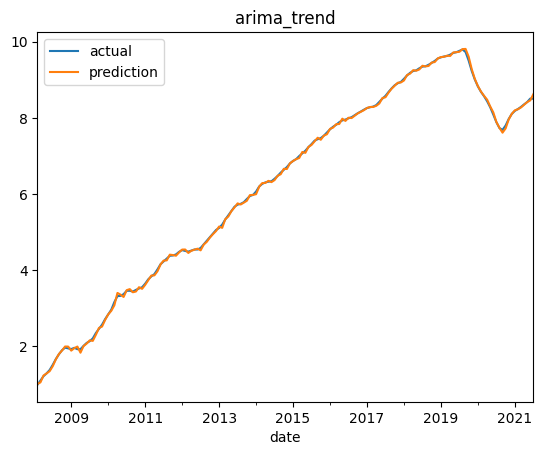

In [100]:
evaluate_and_plot_best(negative_reviews_per_month, lambda_negative, comparison='MSE')

/usr/local/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)


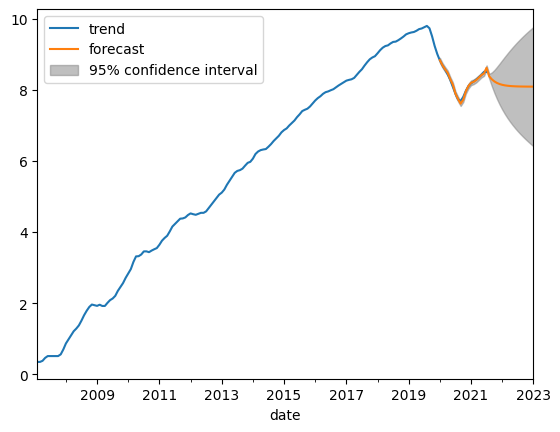

In [101]:
# Plot future forecast for the best model with probability intervals

# Model ARIMA
variable = 'trend'

exam_data = negative_reviews_per_month.copy()[variable]
exam_data = exam_data.dropna()
train = exam_data

# predictions for the next 12 months
model = ARIMA(train, order=(1,1,1))
results = model.fit()
fig, ax = plt.subplots()
ax = train.plot(ax=ax)
plot_predict(results, '2020', '2023', ax=ax)
plt.show()

#### Positive reviews

/usr/local/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dat

Best model: arima_trend
MSE: 0.0012896096056556209


,Model,MAE,MSE,RMSE,MAPE,MASE
0,baseline_mean_box_cox,189.631386,72635.689619,269.510092,75.241538,370.794720
1,baseline_mean_trend,3.580416,15.080115,3.883312,42.844925,37.987966
2,baseline_median_box_cox,183.274580,68563.323251,261.845991,74.267999,358.364973
3,baseline_median_trend,3.384928,13.367385,3.656143,41.188368,35.913851
4,baseline_naive_box_cox,30.312169,2482.534392,49.825038,23.483750,59.270739
5,baseline_naive_trend,0.095932,0.013364,0.115603,1.587338,1.017828
6,ses_box_cox,30.421160,2642.257934,51.402898,22.366318,59.483854
7,ses_trend,0.095932,0.013364,0.115603,1.587338,1.017828
8,arima_box_cox,30.619688,2659.047905,51.565957,23.211609,59.872043
9,arima_trend,0.026394,0.001290,0.035911,0.477841,0.280038


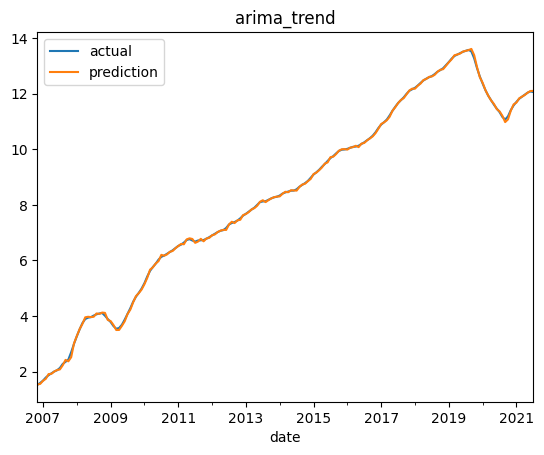

In [102]:
evaluate_and_plot_best(positive_reviews_per_month, lambda_positive, comparison='MSE')

/usr/local/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)


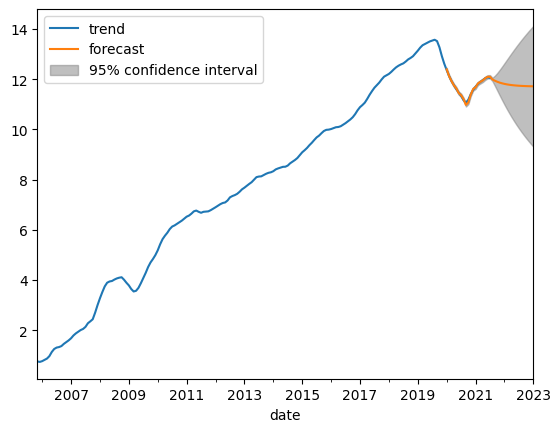

In [103]:
# Plot future forecast for the best model with probability intervals

# Model ARIMA
variable = 'trend'

exam_data = positive_reviews_per_month.copy()[variable]
exam_data = exam_data.dropna()
train = exam_data

# predictions for the next 12 months
model = ARIMA(train, order=(1,1,1))
results = model.fit()
fig, ax = plt.subplots()
ax = train.plot(ax=ax)
plot_predict(results, '2020', '2023', ax=ax)
plt.show()

#### Neutral reviews

/usr/local/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dat

Best model: arima_trend
MSE: 0.0012383910685887316


,Model,MAE,MSE,RMSE,MAPE,MASE
0,baseline_mean_box_cox,24.860227,1107.632376,33.281111,66.047675,52.419939
1,baseline_mean_trend,1.975337,4.484071,2.117563,46.111150,31.532945
2,baseline_median_box_cox,23.254512,976.644823,31.251317,63.240979,49.034150
3,baseline_median_trend,1.758547,3.560775,1.887002,42.813461,28.072249
4,baseline_naive_box_cox,7.069892,96.037634,9.799879,30.047173,14.907480
5,baseline_naive_trend,0.064645,0.007221,0.084977,2.145460,1.031955
6,ses_box_cox,6.578380,91.205863,9.550176,27.906539,13.871083
7,ses_trend,0.064645,0.007221,0.084977,2.145460,1.031955
8,arima_box_cox,6.535213,90.830750,9.530517,27.762121,13.780061
9,arima_trend,0.026637,0.001238,0.035191,1.057610,0.425213


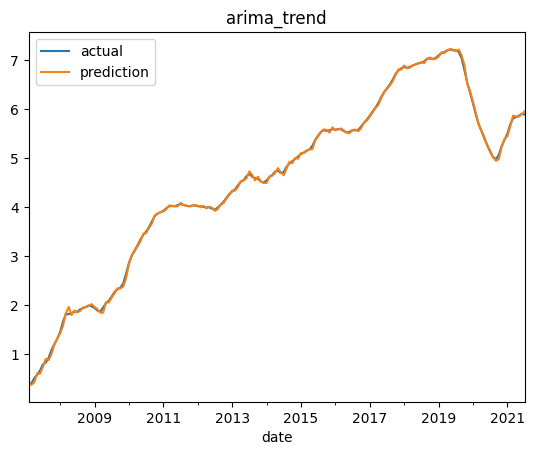

In [104]:
evaluate_and_plot_best(neutral_reviews_per_month, lambda_neutral, comparison='MSE')

/usr/local/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)


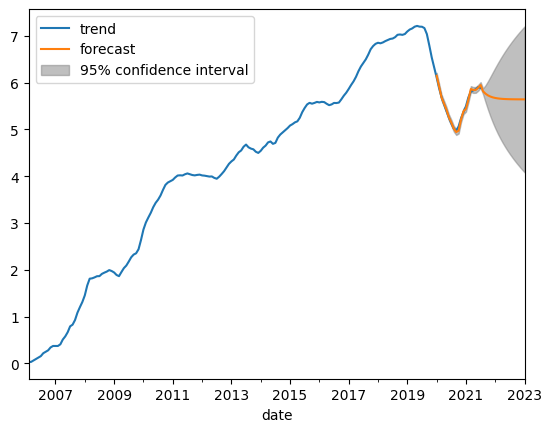

In [105]:
# Plot future forecast for the best model with probability intervals

# Model ARIMA
variable = 'trend'

exam_data = neutral_reviews_per_month.copy()[variable]
exam_data = exam_data.dropna()
train = exam_data

# predictions for the next 12 months
model = ARIMA(train, order=(1,1,1))
results = model.fit()
fig, ax = plt.subplots()
ax = train.plot(ax=ax)
plot_predict(results, '2020', '2023', ax=ax)
plt.show()

#### Sentiment

/usr/local/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dat

Best model: arima_trend
MSE: 1.5843858859243755e-05


,Model,MAE,MSE,RMSE,MAPE,MASE
0,baseline_mean_box_cox,0.174802,0.044230,0.210310,46.740644,3.339894
1,baseline_mean_trend,0.077331,0.007264,0.085229,20.848857,17.890078
2,baseline_median_box_cox,0.119177,0.031497,0.177475,32.168637,2.277089
3,baseline_median_trend,0.052515,0.004168,0.064557,14.845354,12.149108
4,baseline_naive_box_cox,0.100776,0.023136,0.152106,23.471432,1.925500
5,baseline_naive_trend,0.003773,0.000040,0.006342,1.183167,0.872849
6,ses_box_cox,0.087349,0.018713,0.136795,21.387516,1.668944
7,ses_trend,0.003773,0.000040,0.006342,1.183167,0.872849
8,arima_box_cox,0.088423,0.018328,0.135381,22.192761,1.689463
9,arima_trend,0.002584,0.000016,0.003980,0.796873,0.597738


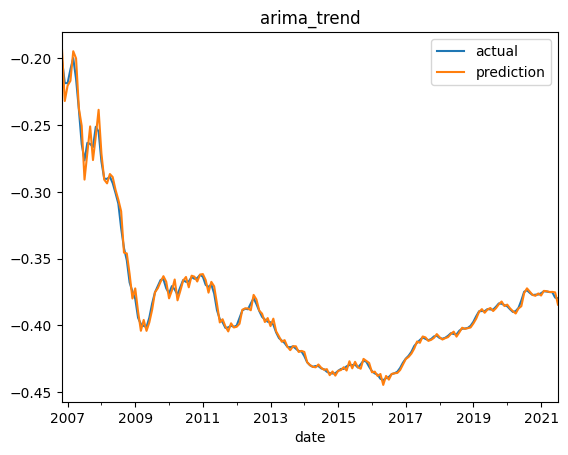

In [106]:
evaluate_and_plot_best(sentiment_per_month, lambda_sentiment, comparison='MSE')

/usr/local/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)


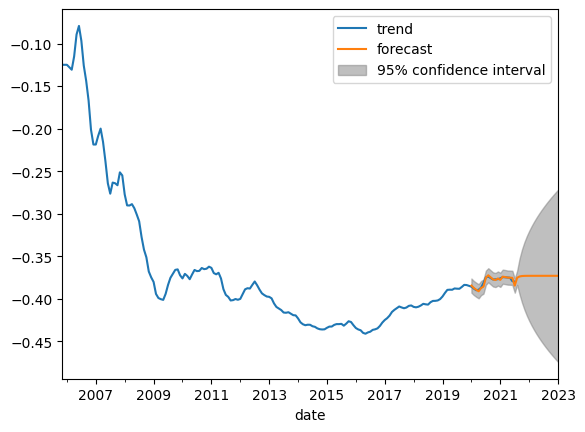

In [107]:
# Plot future forecast for the best model with probability intervals

# Model ARIMA
variable = 'trend'

exam_data = sentiment_per_month.copy()[variable]
exam_data = exam_data.dropna()
train = exam_data

# predictions for the next 12 months
model = ARIMA(train, order=(1,1,1))
results = model.fit()
fig, ax = plt.subplots()
ax = train.plot(ax=ax)
plot_predict(results, '2020', '2023', ax=ax)
plt.show()

#### Restaurant sentiment

/usr/local/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dat

Best model: arima_trend
MSE: 3.8389091134982964e-05


,Model,MAE,MSE,RMSE,MAPE,MASE
0,baseline_mean_box_cox,0.112585,0.028715,0.169456,4.629035,1.491978
1,baseline_mean_trend,0.053095,0.003733,0.061099,4.593707,7.521067
2,baseline_median_box_cox,0.121829,0.041308,0.203244,5.116255,1.614478
3,baseline_median_trend,0.039191,0.002144,0.046306,3.382915,5.551614
4,baseline_naive_box_cox,0.115100,0.031457,0.177362,4.663962,1.525304
5,baseline_naive_trend,0.005683,0.000080,0.008923,0.481142,0.804982
6,ses_box_cox,0.104304,0.027473,0.165750,4.228393,1.382234
7,ses_trend,0.005683,0.000080,0.008923,0.481142,0.804982
8,arima_box_cox,0.099709,0.024922,0.157866,4.081838,1.321343
9,arima_trend,0.003954,0.000038,0.006196,0.335569,0.560112


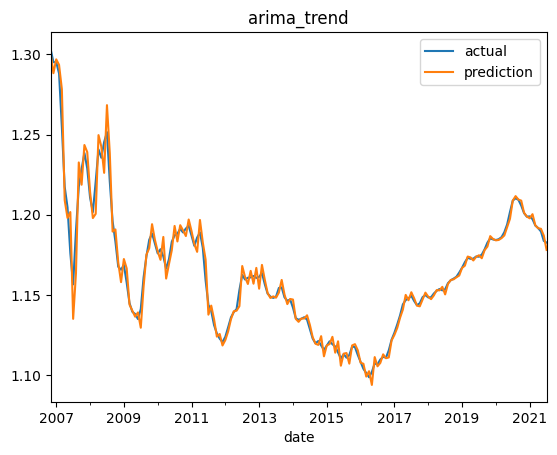

In [108]:
evaluate_and_plot_best(sentiment_restaurants_per_month, lambda_restaurants, comparison='MSE')

/usr/local/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)


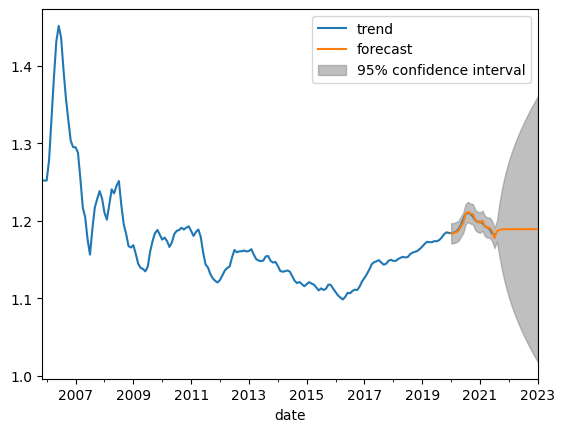

In [109]:
# Plot future forecast for the best model with probability intervals

# Model ARIMA
variable = 'trend'

exam_data = sentiment_restaurants_per_month.copy()[variable]
exam_data = exam_data.dropna()
train = exam_data

# predictions for the next 12 months
model = ARIMA(train, order=(1,1,1))
results = model.fit()
fig, ax = plt.subplots()
ax = train.plot(ax=ax)
plot_predict(results, '2020', '2023', ax=ax)
plt.show()

#### Nightlife sentiment

/usr/local/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dat

Best model: arima_trend
MSE: 0.00010236604115039273


,Model,MAE,MSE,RMSE,MAPE,MASE
0,baseline_mean_box_cox,0.177145,0.086235,0.293659,8.312886,1.624353
1,baseline_mean_trend,0.035561,0.002352,0.048501,3.083172,3.111521
2,baseline_median_box_cox,0.183417,0.127160,0.356595,9.330452,1.681867
3,baseline_median_trend,0.035930,0.002400,0.048985,3.071864,3.143805
4,baseline_naive_box_cox,0.168036,0.096202,0.310165,7.369930,1.540832
5,baseline_naive_trend,0.009609,0.000357,0.018890,0.834602,0.840741
6,ses_box_cox,0.155035,0.088769,0.297941,6.839762,1.421614
7,ses_trend,0.009609,0.000357,0.018890,0.834602,0.840741
8,arima_box_cox,0.151923,0.087984,0.296621,6.713555,1.393076
9,arima_trend,0.005832,0.000102,0.010118,0.506402,0.510303


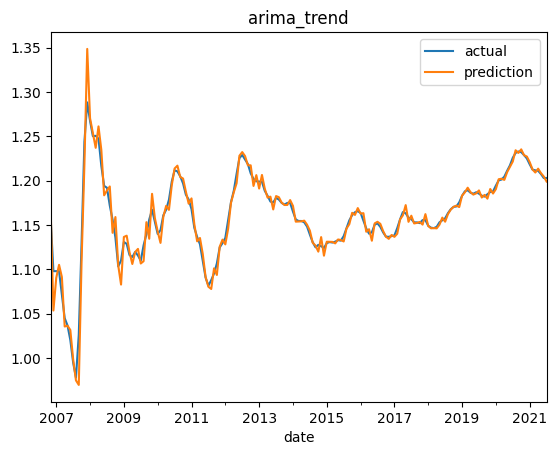

In [110]:
evaluate_and_plot_best(sentiment_nightlife_per_month, lambda_nightlife, comparison='MSE')

/usr/local/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)


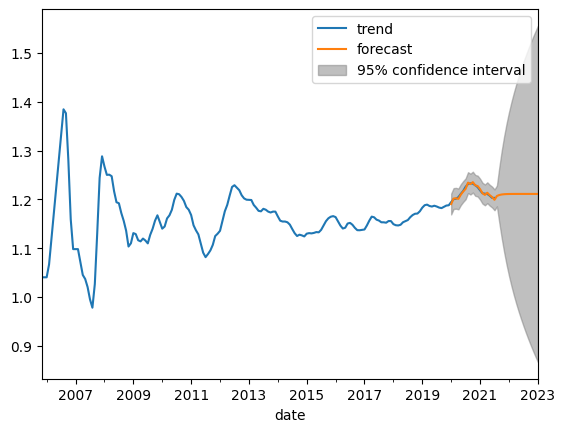

In [111]:
# Plot future forecast for the best model with probability intervals

# Model ARIMA
variable = 'trend'

exam_data = sentiment_nightlife_per_month.copy()[variable]
exam_data = exam_data.dropna()
train = exam_data

# predictions for the next 12 months
model = ARIMA(train, order=(1,1,1))
results = model.fit()
fig, ax = plt.subplots()
ax = train.plot(ax=ax)
plot_predict(results, '2020', '2023', ax=ax)
plt.show()

#### Breakfast & brunch sentiment

/usr/local/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/site-packages/statsmodels/tsa/holtwinters/model.py:1411: RuntimeWarning: divide by zero encountered in log
  aic = self.nobs * np.log(sse / self.nobs) + k * 2
/usr/local/lib/python3.11/site-packages/statsmodels/tsa/holtwinters/model.py:1418: RuntimeWarning: divide by zero encountered in log
  bic = self.nobs * np.log(sse / self.nobs) + k * np.log(self.nobs)
/usr/local/lib/python3.11/site-packages/statsmodels/tsa/holtwinters/model.py:1411: RuntimeWarning: divide by zero encountered in log
  aic = self.nobs * np.log(sse / self.nobs) + k * 2
/usr/local/lib/python3.11/site-packages/statsmodels/tsa/holtwinters/model.py:1418: RuntimeWarning: divide by zero encountered in log
  bic = self.nobs * np.log(sse / self.nobs) + k * np.log(self.nobs)
/usr/local/lib/python3.11/

Best model: arima_trend
MSE: 6.025943920785763e-05


/usr/local/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


,Model,MAE,MSE,RMSE,MAPE,MASE
0,baseline_mean_box_cox,0.172762,0.061607,0.248208,7.442919,1.616371
1,baseline_mean_trend,0.057972,0.004842,0.069586,5.116062,6.871973
2,baseline_median_box_cox,0.196721,0.089113,0.298517,8.546060,1.840534
3,baseline_median_trend,0.045017,0.003401,0.058319,3.959644,5.336284
4,baseline_naive_box_cox,0.177765,0.067870,0.260519,7.283278,1.663175
5,baseline_naive_trend,0.007555,0.000120,0.010935,0.655088,0.895518
6,ses_box_cox,0.163666,0.056077,0.236807,6.713926,1.531267
7,ses_trend,0.007555,0.000120,0.010935,0.655088,0.895518
8,arima_box_cox,0.156395,0.051993,0.228020,6.449745,1.463239
9,arima_trend,0.005429,0.000060,0.007763,0.470549,0.643511


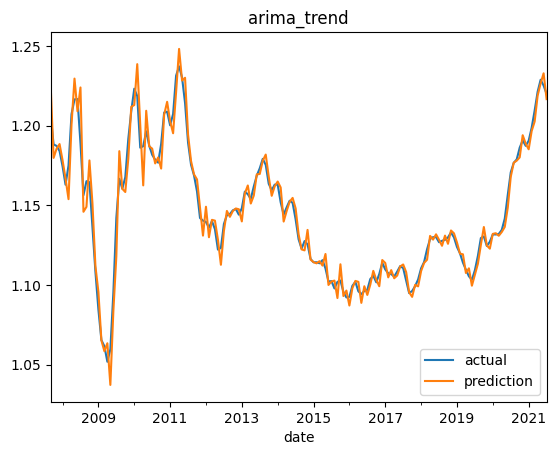

In [112]:
evaluate_and_plot_best(sentiment_breakfast_brunch_per_month, lambda_breakfast_brunch, comparison='MSE')

/usr/local/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


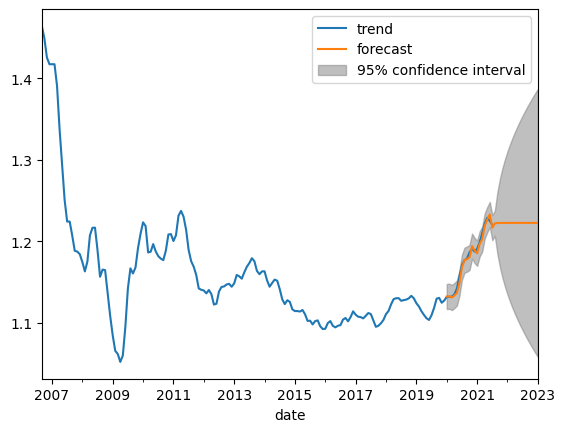

In [113]:
# Plot future forecast for the best model with probability intervals

# Model ARIMA
variable = 'trend'

exam_data = sentiment_breakfast_brunch_per_month.copy()[variable]
exam_data = exam_data.dropna()
train = exam_data

# predictions for the next 12 months
model = ARIMA(train, order=(1,1,1))
results = model.fit()
fig, ax = plt.subplots()
ax = train.plot(ax=ax)
plot_predict(results, '2020', '2023', ax=ax)
plt.show()